In [1]:
from google.colab import drive 
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import argparse
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from time import *
from numpy import asarray
import os
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
data = []
labels = []

In [ ]:
def load_image(name,category):
  path = '/content/drive/MyDrive/Data/'
  for key, value in enumerate(os.listdir(path + name)):
    image = load_img((path + name+'/'+value), target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image),labels.append(category)

In [ ]:
data = asarray(data)
labels = asarray(labels)
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(3000, 3)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape = (224, 224, 3), classes = 3)
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS, 
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS, 
	epochs=EPOCHS)

Epoch 1/20
72/72 [==============================] - 138s 2s/step - loss: 1.0763 - accuracy: 0.5162 - val_loss: 0.3297 - val_accuracy: 0.8912
Epoch 2/20
72/72 [==============================] - 129s 2s/step - loss: 0.3804 - accuracy: 0.8465 - val_loss: 0.2312 - val_accuracy: 0.9257
Epoch 3/20
72/72 [==============================] - 130s 2s/step - loss: 0.2567 - accuracy: 0.9048 - val_loss: 0.1948 - val_accuracy: 0.9292
Epoch 4/20
72/72 [==============================] - 137s 2s/step - loss: 0.2260 - accuracy: 0.9110 - val_loss: 0.1693 - val_accuracy: 0.9465
Epoch 5/20
72/72 [==============================] - 126s 2s/step - loss: 0.2135 - accuracy: 0.9186 - val_loss: 0.1511 - val_accuracy: 0.9465
Epoch 6/20
72/72 [==============================] - 127s 2s/step - loss: 0.1698 - accuracy: 0.9375 - val_loss: 0.1355 - val_accuracy: 0.9585
Epoch 7/20
72/72 [==============================] - 127s 2s/step - loss: 0.1963 - accuracy: 0.9296 - val_loss: 0.1246 - val_accuracy: 0.9534
Epoch 8/20
72

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)

In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)

In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names =['0','1','2']))


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       188
           1       0.95      0.96      0.96       191
           2       0.99      1.00      1.00       200

    accuracy                           0.97       579
   macro avg       0.97      0.97      0.97       579
weighted avg       0.97      0.97      0.97       579



In [ ]:
model.save('/content/drive/MyDrive/Data/Model/mask-detector-model.model', save_format="h5")

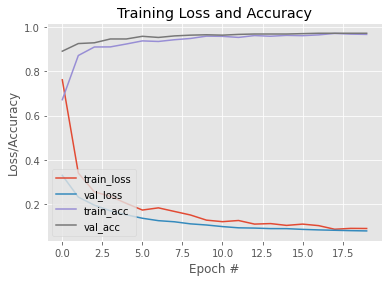

In [ ]:
N = EPOCHS
plt.style.use("ggplot") 
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('evaluation.png')